## Mud card answers
- **When creating n imputed datasets, is there a downside to simply taking the average of those imputed values and using that to run the ML models, as opposed to testing each imputed dataset separately?**
    - yes, you will not be able to measure the uncertainty of the test score caused by the imputation
- **"When using the multivariate imputation (if we are forced to impute for some reason), should we include a random state in our model? Not just in the imputer, but also the model?**
    - if the model you use is non-deterministic, yes.
- **for ordinal imputing, the NAN's are always made the first one in order?**
    - that's a difficult question
    - first or last is used usually
    - if you are unsure which one is better, try both approaches and compare test scores
- **I am still a bit confused on what the reduced features approach is actually doing/predicting.**
    - you should read the papers linked in the lecture notes
    - we train multiple models (one model per missingness pattern) which can be numerically expensive
    - but each model we create is based on a complete feature matrix so there is no need to impute
- **While I understand that pre-processing effectively handles missing values for categorical features, could there not be some scenarios where we might want to impute a (categorical) value for each row with missing data from among the 'actual' categories? Or does it not really matter in the context of training data? Would the methods we went over today be able to handle this?**
    - I couldn't come up with a scenario where you would want to impute missing values in a categorical or ordinal feature
    - if you have a scenario, let me know. I'd be happy to discuss.
- **When you applied the XGoost with reduced-features, does it mean there will be no missing values for XGoost to deal with since reduced-features has already excluded all the missing ones to perform the model**
    - yes
    - we could have used any other model with the reduced features approach
    - I used XGB for compatibility with the other methods I described in class
- **I am confused about why imputation is bad for missing data that is missing because of research error. For example, missing cell counts in certain brain regions because of bad imaging. In this case the missing values aren't really related to control or experimental groups, so keeping track of where the missing values are doesn't really make much sense to me.**
    - you try to guess what a certain value is eventhough you have no way of verifying how accurate your guess is
    - so why do it? why would you alter your dataset? 
    - it's much better to keep your dataset as is and change methods instead
    - also, you might have no way of knowing why the values are missing
        - why are some images bad?
        - maybe there is a sloppy technician who doesn't know how to use the microscope properly?
        - maybe the microscope broke and the technicians didn't notice it for a while
        - any possible reason could be indirectly related to certain control or experiemtnal groups
- **I'm still confused about the reduced features when all features are not missing. What is the target variable when we train the model for this pattern if no feature is missing?**
    - your original target variable
- **With the reduced feature approach, we were told that it can handle na's. Can we opt to not impute missing values from categorical/ordinal if we want to thus increasing the number of patterns? It feels doable but might not be as efficient as imputing first.**
    - I wouldn't do it, it's unnecessary
- **I don't fully understand the code with RDF**
    - what's RDF?
    - could you post on ED Discussion or come to the office hours?

## Global feature importance metrics
By the end of this module, you will be able to
 - perform permutation feature importance calculation
 - study the coefficients of linear models
 - outlook to other metrics 

## The supervised ML pipeline
The goal: Use the training data (X and y) to develop a <font color='red'>model</font> which can <font color='red'>accurately</font> predict the target variable (y_new') for previously unseen data (X_new).

**1. Exploratory Data Analysis (EDA)**: you need to understand your data and verify that it doesn't contain errors
   - do as much EDA as you can!
    
**2. Split the data into different sets**: most often the sets are train, validation, and test (or holdout)
   - practitioners often make errors in this step!
   - you can split the data randomly, based on groups, based on time, or any other non-standard way if necessary to answer your ML question

**3. Preprocess the data**: ML models only work if X and Y are numbers! Some ML models additionally require each feature to have 0 mean and 1 standard deviation (standardized features)
   - often the original features you get contain strings (for example a gender feature would contain 'male', 'female', 'non-binary', 'unknown') which needs to transformed into numbers
   - often the features are not standardized (e.g., age is between 0 and 100) but it needs to be standardized
    
**4. Choose an evaluation metric**: depends on the priorities of the stakeholders
   - often requires quite a bit of thinking and ethical considerations
     
**5. Choose one or more ML techniques**: it is highly recommended that you try multiple models
   - start with simple models like linear or logistic regression
   - try also more complex models like nearest neighbors, support vector machines, random forest, etc.
    
**6. Tune the hyperparameters of your ML models (aka cross-validation)**
   - ML techniques have hyperparameters that you need to optimize to achieve best performance
   - for each ML model, decide which parameters to tune and what values to try
   - loop through each parameter combination
       - train one model for each parameter combination
       - evaluate how well the model performs on the validation set
   - take the parameter combo that gives the best validation score
   - evaluate that model on the test set to report how well the model is expected to perform on previously unseen data
    
<span style="background-color: #FFFF00"> **7. Interpret your model**: black boxes are often not useful</span>
   - check if your model uses features that make sense (excellent tool for debugging)
   - often model predictions are not enough, you need to be able to explain how the model arrived to a particular prediction (e.g., in health care)

## Motivation
 - debugging ML models is tough
    - a model that runs without errors/warning is not necessarily correct
 - how do you know that your model is correct?
    - check test set predictions
       - in regression: check points with a large difference between true and predicted values
       - in classification: confusion matrix, check out FPs and FNs
    - inspect your model
       - especially useful for non-linear models
       - metrics to measure how much a model depends on a feature is one way to inspect your model

## <font color='LIGHTGRAY'>Global feature importance metrics</font>
<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
 - **perform permutation feature importance calculation**
 - <font color='LIGHTGRAY'>study coefficients of linear models</font>
 - <font color='LIGHTGRAY'>outlook to other metrics </font>

## Permutation feature importance
 - model agnostic, you can use it with any supervised ML model
 - steps:
    - train a model and calculate a test score :)
    - randomly shuffle a single feature in the test set
    - recalculate the test score with the shuffled data
    - model score worsens because the shuffling breaks the relationship between feature and target
    - the larger the difference, the more important the feature is

In [2]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt

df = pd.read_csv('data/adult_data.csv')
label = 'gross-income'
y = df[label]
df.drop(columns=[label],inplace=True)
X = df
ftr_names = X.columns
print(X.head())
print(y)

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0          2174             0              40   United-States  
1           

In [3]:
def ML_pipeline_kfold(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    pipe = make_pipeline(preprocessor,SVC())
    # the parameter(s) we want to tune
    param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100],
                  'svc__gamma': [0.01, 0.1, 1, 10, 100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1,verbose=True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, X_test, y_test

## Be careful, SVM is used on a relatively large dataset

In [4]:
model, X_test, y_test = ML_pipeline_kfold(X,y,42,4)
print(model.best_score_)
print(model.score(X_test,y_test))
print(model.best_params_)

# save the output so I can use it later
import pickle
file = open('results/grid.save', 'wb')
pickle.dump((model,X_test,y_test),file)
file.close()

Fitting 4 folds for each of 25 candidates, totalling 100 fits
0.8545377764127764
0.8624289881774911
{'svc__C': 1, 'svc__gamma': 0.1}


In [4]:
import pickle
file = open('results/grid.save', 'rb')
model, X_test, y_test = pickle.load(file)
file.close()

np.random.seed(42)

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = model.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == ' <=50K')/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(model.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8624289881774911
test baseline =  0.7587901120835252
shuffling age
   shuffled test score: 0.851 +/- 0.002
shuffling workclass
   shuffled test score: 0.861 +/- 0.001
shuffling fnlwgt
   shuffled test score: 0.862 +/- 0.001
shuffling education
   shuffled test score: 0.86 +/- 0.001
shuffling education-num
   shuffled test score: 0.839 +/- 0.002
shuffling marital-status
   shuffled test score: 0.842 +/- 0.002
shuffling occupation
   shuffled test score: 0.844 +/- 0.002
shuffling relationship
   shuffled test score: 0.851 +/- 0.003
shuffling race
   shuffled test score: 0.862 +/- 0.0
shuffling sex
   shuffled test score: 0.862 +/- 0.0
shuffling capital-gain
   shuffled test score: 0.823 +/- 0.001
shuffling capital-loss
   shuffled test score: 0.855 +/- 0.001
shuffling hours-per-week
   shuffled test score: 0.855 +/- 0.002
shuffling native-country
   shuffled test score: 0.862 +/- 0.001


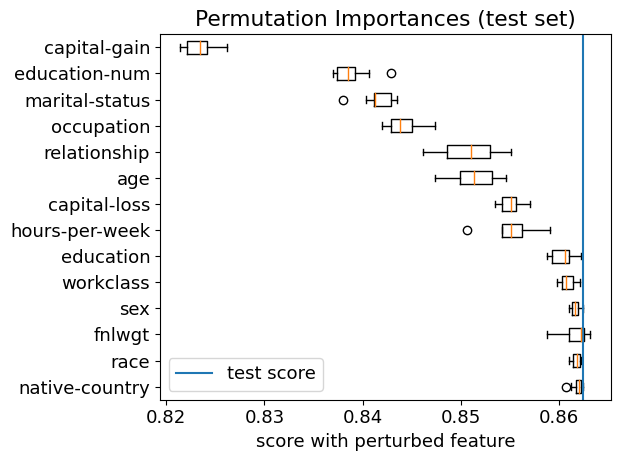

In [5]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6.4,4.8))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

## Check out sklearn's permutation importance!

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

## Cons of permutation feature importance
- strongly correlated features
   - if one of the features is shuffled, the model can still use the other correlated feature
   - both features appear to be less important but they might actually be important
   - solution:
      - check the correlation matrix plot
      - remove all but one of the strongly correlated features
- no feature interactions
   - one feature might appear unimportant but combined with another feature could be important
   - solution:
      - permute two features to measure how important feature pairs are
      - this can be computationally expensive

## Quiz

## <font color='LIGHTGRAY'>Global feature importance metrics</font>
<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
 - <font color='LIGHTGRAY'>perform permutation feature importance calculation</font>
 - **study the coefficients of linear models**
 - <font color='LIGHTGRAY'>outlook to other metrics </font>

## Coefficients of linear models
- the coefficients of linear and logistic regression can be used as a measure of feature importance **ONLY IF** all features have a zero mean and the same standard deviation (usually 1)
   - all features meaning that the one-hot encoded and ordinal features as well!
- then the absolute value of the coefficients can be used to rank them

## Let's rewrite the kfold CV function a bit

In [6]:
from sklearn.linear_model import LogisticRegression
def ML_pipeline_kfold_LR1(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    pipe = make_pipeline(preprocessor,LogisticRegression(penalty='l2',solver='lbfgs',max_iter=10000000))
    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10,100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = cont_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

/Users/azsom/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


test score: 0.8584369722094273


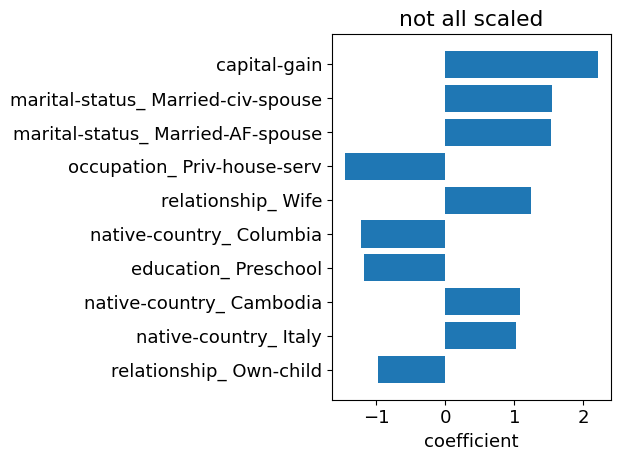

In [7]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold_LR1(X,y,42,4)
print('test score:',grid.score(X_test,y_test))
coefs = grid.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.figure(figsize=(6.4,4.8))
plt.rcParams.update({'font.size': 13})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('not all scaled')
plt.tight_layout()
plt.savefig('figures/LR_coefs_notscaled.png',dpi=300)
plt.show()

In [8]:
from sklearn.linear_model import LogisticRegression
def ML_pipeline_kfold_LR2(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    final_scaler = StandardScaler()
    pipe = make_pipeline(preprocessor,final_scaler,LogisticRegression(penalty='l2',solver='lbfgs'))
    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10,100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = cont_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

/Users/azsom/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


test score: 0.857976354982343


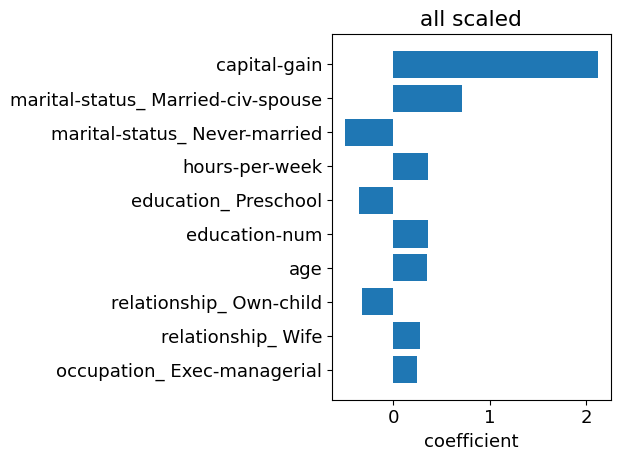

In [9]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold_LR2(X,y,42,4)
print('test score:',grid.score(X_test,y_test))
coefs = grid.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.figure(figsize=(6.4,4.8))
plt.rcParams.update({'font.size': 13})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('all scaled')
plt.tight_layout()
plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
plt.show()

<table><tr>
<td> <img src="figures/LR_coefs_notscaled.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="figures/LR_coefs_scaled.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

## <font color='LIGHTGRAY'>Global feature importance metrics</font>
<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
 - <font color='LIGHTGRAY'>perform permutation feature importance calculation</font>
 - <font color='LIGHTGRAY'>study the coefficients of linear models</font>
 - **outlook to other metrics**


- SVM:
   - SVC.coef_ and SVR.coef_ can be used as a metric of feature importance if **all** features are standardized
   - for linear SVMs only!
- random forest:
   - RandomForestRegressor.feature_importances_ and RandomForestClassification.feature_importances_
   - gini importance or mean decrease impurity, see [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) and [here](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)
- XGBoost:
   - five different metrics are implemented, see [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score) and [here](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

## Quiz

## Mudcard